# MuchLearningSuchWow - LSTM - Training

This notebook contains the code we used to define and train our LSTM network to predict sales for the validation and evaluation datasets. The training code is based loosely on [this kernel](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7).

### Imports & Data Paths

In [1]:
import numpy as np
import pandas as pd
import pickle
import gc

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
inputPath = "input/m5-forecasting-accuracy/"
outputPath = "output/"
modelPath = "models/"

### Constants

In [3]:
timesteps = 14 # Number of previous days that will be used to predict the next day
startDay = 1000 # Number of days at start of data that will be ignored during training

# Model settings
add_1dConv = False
node_setup = (50, 400, 400) # Baseline: (50, 400, 400), new setup: (150, 300, 400)
learning_rate = 0.0001

# Training loop settings
nr_epochs = 3
batch_size = 32

### Loading Data

In [4]:
with open(outputPath + "/preprocessed_train_valid_data.pkl", "rb") as f:
    df_train_valid = pickle.load(f)
with open(outputPath + "/item_data.pkl", "rb") as f:
    item_data = pickle.load(f)
print(df_train_valid.shape)

(941, 30491)


In [5]:
# Remove Kaggle validation data for the validation model
df_train = df_train_valid[:-28] 
print(df_train.shape)

(913, 30491)


### LSTM Model

In [6]:
def create_LSTM():
    model = Sequential()

    # 1D convolution layer
    if(add_1dConv):
        model.add(Conv1D(filters=32, kernel_size=7, strides=1, 
                         padding="causal", activation="relu",
                         input_shape=(item_data.shape[0]+timesteps, # == X_train.shape[1]
                                      df_train.shape[1]))) # == X_train.shape[2] (df_train.shape[1] == df_train_valid.shape[1])

    # LSTM layers
    layer_1_units, layer_2_units, layer_3_units = node_setup
    
    if(add_1dConv):
        model.add(LSTM(units = layer_1_units, return_sequences = True))
    else:
        model.add(LSTM(units = layer_1_units, 
                       return_sequences = True, 
                       input_shape=(item_data.shape[0]+timesteps, df_train.shape[1])))
    model.add(Dropout(0.3))

    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.3))

    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(units = 30490))
    
    return model

In [7]:
model = create_LSTM()
plot_model(model, modelPath + "/model.png")
print(model.summary())
del model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 50)            6108400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 400)           721600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30490)            

In [8]:
# Define the loss function (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

### Validation Model

##### Scaling

In [9]:
valid_scaler = MinMaxScaler(feature_range = (0, 1))
df_train_scaled = valid_scaler.fit_transform(df_train)

##### Creating Training Data & Labels

In [10]:
X_train_valid = []
y_train_valid = []
for i in range(timesteps, 1913 - startDay):
    X_train_valid.append(np.append(item_data, df_train_scaled[i-timesteps:i], axis = 0))
    y_train_valid.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels
del df_train_scaled

In [11]:
# Convert data to np array to be able to feed it to the model
X_train_valid = np.array(X_train_valid)
y_train_valid = np.array(y_train_valid)
print(X_train_valid.shape)
print(y_train_valid.shape)

(899, 14, 30491)
(899, 30490)


##### Training Loop

In [12]:
# Create the validation model
valid_model = create_LSTM()

# Compile the validation model
valid_model.compile(optimizer = Adam(learning_rate=learning_rate), loss = root_mean_squared_error)

# Fit the validation model to the validation training set
valid_history = valid_model.fit(X_train_valid, y_train_valid, 
                                epochs = nr_epochs, 
                                batch_size = batch_size, 
                                verbose = 1)

Epoch 1/3
899/899 [==============================] - 18s 20ms/step - loss: 0.1664
Epoch 2/3
899/899 [==============================] - 17s 18ms/step - loss: 0.1462
Epoch 3/3
899/899 [==============================] - 17s 18ms/step - loss: 0.1448


##### Cleanup

In [13]:
del X_train_valid
del y_train_valid
gc.collect()

987

### Evaluation Model

##### Scaling

In [14]:
# Scale the data for the evaluation model
eval_scaler = MinMaxScaler(feature_range = (0, 1))
df_train_valid_scaled = eval_scaler.fit_transform(df_train_valid)

##### Creating Training Data & Labels

In [15]:
# Create training data and labels for the evaluation model
X_train_eval = []
y_train_eval = []
for i in range(timesteps, 1941 - startDay):
    X_train_eval.append(np.append(item_data, df_train_valid_scaled[i-timesteps:i], axis = 0))
    y_train_eval.append(df_train_valid_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels
del df_train_valid_scaled

In [16]:
# Convert data to np array to be able to feed it to the model
X_train_eval = np.array(X_train_eval)
y_train_eval = np.array(y_train_eval)
print(X_train_eval.shape)
print(y_train_eval.shape)

(927, 14, 30491)
(927, 30490)


##### Training Loop

In [17]:
# Create the evaluation model
eval_model = create_LSTM()

# Compile the evaluation model
eval_model.compile(optimizer = Adam(learning_rate=learning_rate), loss = root_mean_squared_error)

# Fit the validation model to the evaluation training set
eval_history = eval_model.fit(X_train_eval, y_train_eval, 
                              epochs = nr_epochs, 
                              batch_size = batch_size, 
                              verbose = 1)

Epoch 1/3
927/927 [==============================] - 17s 19ms/step - loss: 0.1657
Epoch 2/3
927/927 [==============================] - 17s 18ms/step - loss: 0.1456
Epoch 3/3
927/927 [==============================] - 17s 18ms/step - loss: 0.1442


##### Cleanup

In [18]:
del X_train_eval
del y_train_eval
gc.collect()

73

### Saving Result

In [19]:
valid_model.save(modelPath + "/lstm_model_valid")
eval_model.save(modelPath + "/lstm_model_eval")

In [20]:
with open(outputPath + "/scalers.pkl", "wb") as f:
    pickle.dump((valid_scaler, eval_scaler), f)

### Plotting Losses

In [21]:
def plot_loss(history, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(1, nr_epochs+1), history.history['loss'], label='train_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

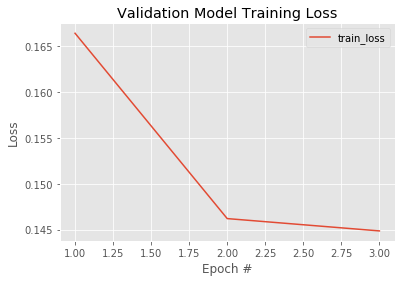

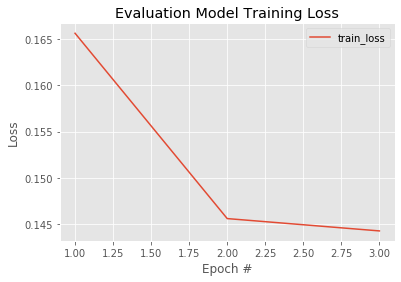

In [22]:
plot_loss(valid_history, nr_epochs, 'Validation Model Training Loss')
plot_loss(eval_history, nr_epochs, 'Evaluation Model Training Loss')